---
### **Forecasting Household Electric Power Consumption using LSTM**
---

This dataset contains 2,075,259 one-minute measurements of electric power consumption in a single household over almost four years (December 2006 to November 2010). The data includes various electrical quantities and sub-metering values.

**Dataset Characteristics**

* Multivariate
* Time-Series

**Dataset Information**

The archive was gathered from a house in Sceaux, France, with some missing values present. Additional notes:

1. The active energy consumed every minute is represented by `(global_active_power * 1000 / 60 - sub_metering_1 - sub_metering_2 - sub_metering_3)`.
2. Missing values occur about 1.25% of the time, marked with a missing value between consecutive semi-colon attribute separators.

**Variables Table**

| Variable Name | Role | Type |
| --- | --- | --- |
| Date | Feature | Date |
| Time | Feature | Categorical |
| Global_active_power | Feature | Continuous |
| Global_reactive_power | Feature | Continuous |
| Voltage | Feature | Continuous |
| Global_intensity (Current) | Feature | Continuous |
| Sub_metering_1  *Sub-metering No. 1*   (kW-h) Energy sub-metering for kitchen | Feature | Continuous |
| Sub_metering_2  *Sub-metering No. 2*   (kW-h) Energy sub-metering for laundry room | Feature | Continuous |
| Sub_metering_3  *Sub-metering No. 3*   (kW-h) Energy sub-metering for electric water-heater and air-conditioner | Feature | Continuous |

**Dataset Link:**

https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

---

#### **What is Active and Reactive Power?**

**Active power**

Also known as real or true power, active power is the useful power that is dissipated in a circuit and used to make devices operate. It is measured in watts (W) and is the product of voltage, current, and the cosine of the angle between them.

**Reactive power**

Reactive power is power that is stored in a circuit and oscillates between the generation source and the load. It does not do work in the system. Reactive power can arise in the external network and in the local network, and may be caused by the energy supplier as well as the end user.

**This indicates that the task is to forecast active power using the provided features by leveraging a time series model, specifically LSTM.**

---

#### **Importing Libraries**

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


---

#### **Loading Dataset**

---

In [2]:
# df_train = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt")
df = pd.read_csv("household_power_consumption.txt", sep=";") # as the data is separated by ;
df


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


---

#### **Exploratory Data Analysis**

---

In [3]:
# What is the shape of the data? i.e. Number of Rows and Columns

df.shape


(2075259, 9)

In [4]:
# What are the column names and data types?

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
# How many unique values are available in each column?

df.apply(lambda x: x.nunique())


Date                     1442
Time                     1440
Global_active_power      6534
Global_reactive_power     896
Voltage                  5168
Global_intensity          377
Sub_metering_1            153
Sub_metering_2            145
Sub_metering_3             32
dtype: int64

---

#### **Feature Engineering**

---

In [6]:
# Let's combine the date and time columns to create a single DateTime column and also transform it to datetime format

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.drop(['Date', 'Time'], axis=1, inplace=True)
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00
...,...,...,...,...,...,...,...,...
2075254,0.946,0.0,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00
2075255,0.944,0.0,240.0,4.0,0.0,0.0,0.0,2010-11-26 20:59:00
2075256,0.938,0.0,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00
2075257,0.934,0.0,239.7,3.8,0.0,0.0,0.0,2010-11-26 21:01:00


In [7]:
# Can we change the DateTime column to be the index?

df.set_index('DateTime', inplace=True)
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0


In [8]:
# What about other column data types? They are object. Let's convert then to numeric 

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [9]:
# How many missing values or null values are there in each column?

df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [10]:
# Let's get the stastistical summary of the data for each column before filling the missing values

desc = df.describe()
desc_formatted = desc.applymap(lambda x: f"{x:.4f}")
desc_formatted

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2049280.0000
mean,1.0916,0.1237,240.8399,4.6278,1.1219,1.2985,6.4584
std,1.0573,0.1127,3.2400,4.4444,6.1530,5.8220,8.4372
min,0.0760,0.0000,223.2000,0.2000,0.0000,0.0000,0.0000
25%,0.3080,0.0480,238.9900,1.4000,0.0000,0.0000,0.0000
50%,0.6020,0.1000,241.0100,2.6000,0.0000,0.0000,1.0000
75%,1.5280,0.1940,242.8900,6.4000,0.0000,1.0000,17.0000
max,11.1220,1.3900,254.1500,48.4000,88.0000,80.0000,31.0000


In [11]:
# Which method should we use to fill the missing values? 
# Let's fill the missing values with the time based interpolation method

df.interpolate(method='time', inplace=True)


In [12]:
# Let's get the stastistical summary of the data for each column after filling the missing values

desc = df.describe()
desc_formatted = desc.applymap(lambda x: f"{x:.4f}")
desc_formatted

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259.0000,2075259.0000,2075259.0000,2075259.0000,2075259.0000,2075259.0000,2075259.0000
mean,1.0903,0.1236,240.8328,4.6215,1.1095,1.2892,6.4424
std,1.0526,0.1124,3.2378,4.4244,6.1158,5.7866,8.4159
min,0.0760,0.0000,223.2000,0.2000,0.0000,0.0000,0.0000
25%,0.3100,0.0480,238.9900,1.4000,0.0000,0.0000,0.0000
50%,0.6140,0.1000,241.0000,2.7516,0.0000,0.0000,1.0000
75%,1.5280,0.1940,242.8700,6.4000,0.0000,1.0000,17.0000
max,11.1220,1.3900,254.1500,48.4000,88.0000,80.0000,31.0000


**Observations**

1. There is not much impact on the statistical properties of data after filling the missing values. 
2. Hence, we will go ahead with the new data after filling the missing values.

In [13]:
# How many missing values or null values are still there?

df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

---

#### **Data Visualization and Analysis**

---

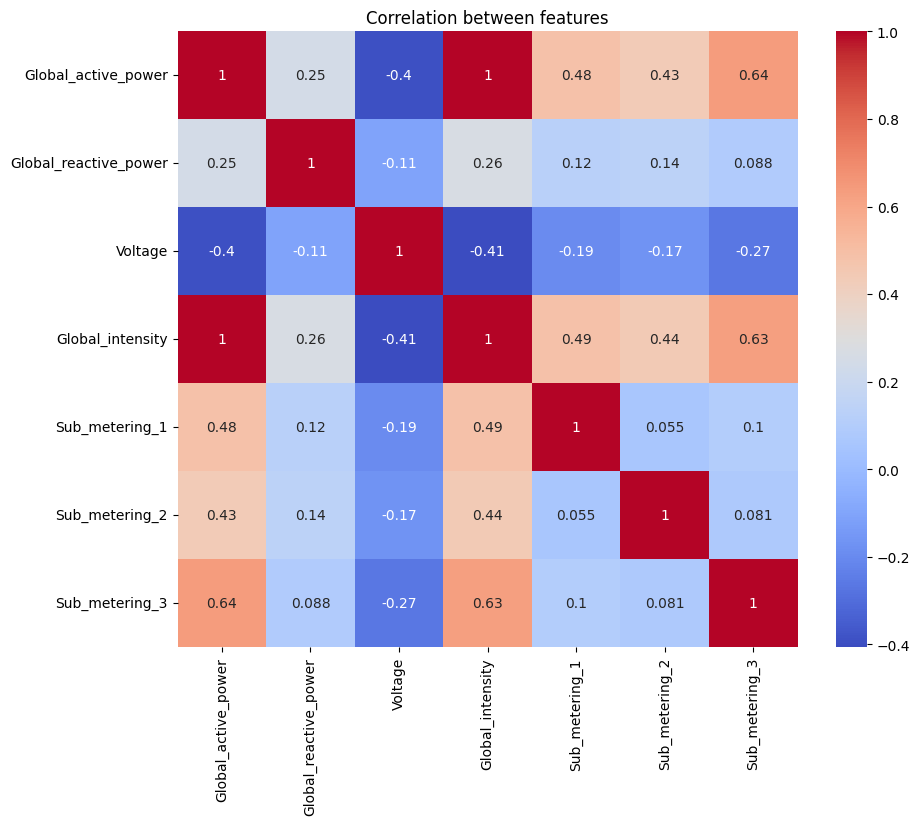

In [14]:
# What is correlation between the Global_active_power and other columns on basis of the given 1 minute data?

correlation_data = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()


**Observations:**

As shown in above heatmap,

1. Global_active_power is the most correlated with Global_intensity, Sub_metering_3, Sub_metering_2 and Sub_metering_1.

2. Global_active_power is negatively correlated with Voltage. So when Voltage is high, Global_active_power is low and vice versa.


**Correlation between features**

(69177, 7)


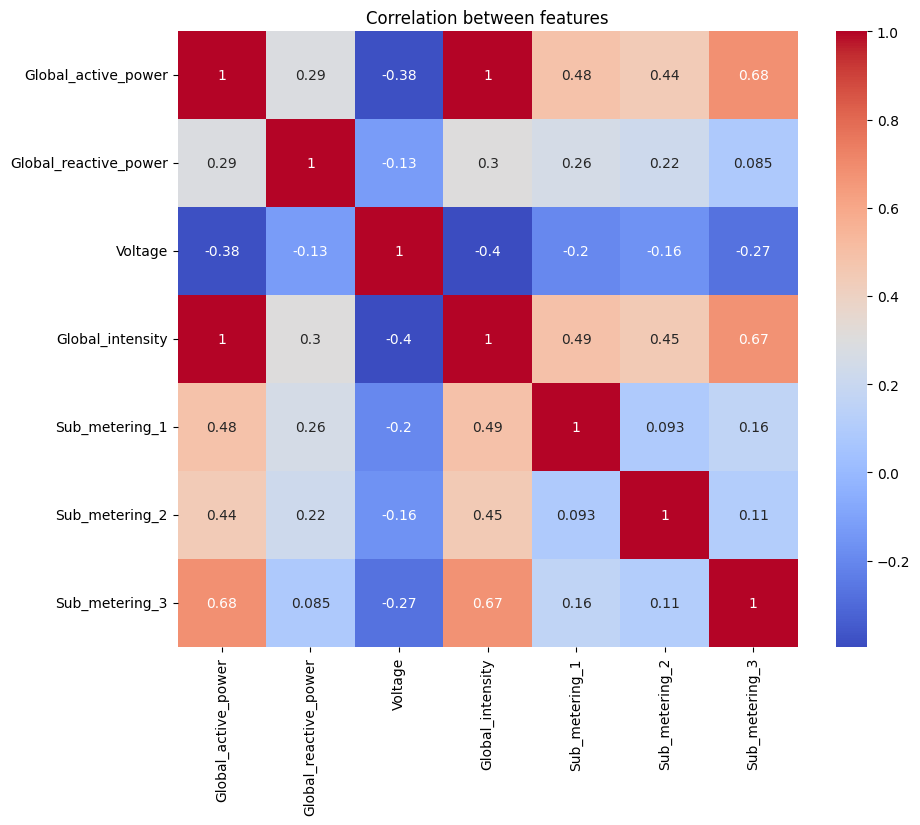

In [15]:
# What is correlation between the Global_active_power and other columns on basis of the given 30 minute data?

df_resampled_30mins = df.resample('30min').mean()
print(df_resampled_30mins.shape)

correlation_data = df_resampled_30mins.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

(34589, 7)


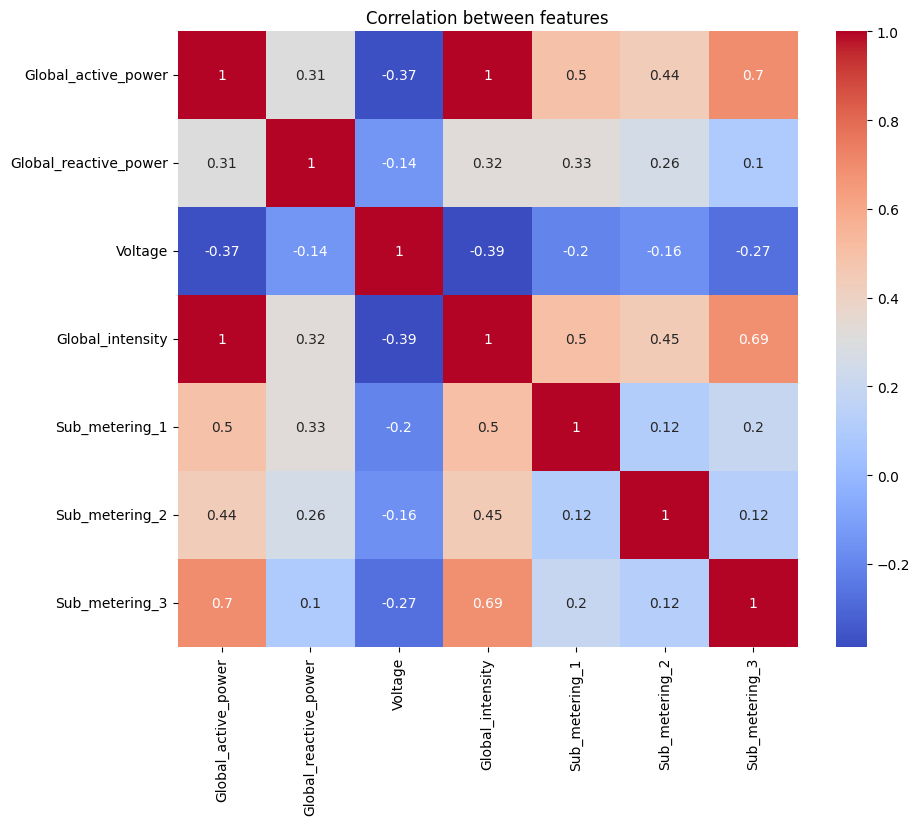

In [16]:
# What is correlation between the Global_active_power and other columns on basis of the given 1 hour data?

df_resampled_hourly = df.resample('h').mean()
print(df_resampled_hourly.shape)

correlation_data = df_resampled_hourly.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()


(1442, 7)


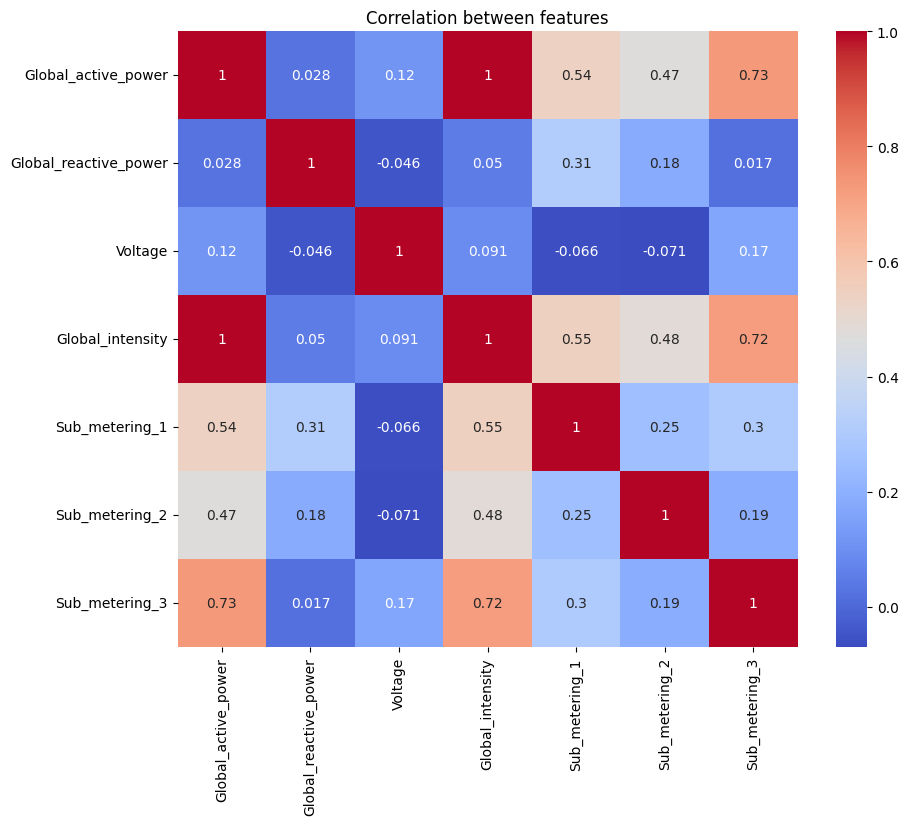

In [17]:
# What is correlation between the Global_active_power and other columns on basis of the given 1 day data?

df_resampled_daily = df.resample('D').mean()
print(df_resampled_daily.shape)

correlation_data = df_resampled_daily.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()


**Observations:**

After analyzing the correlation matrix for the resampled data at 1 minute, 30 minutes, 1 hour, and 1 day intervals, we observed the following:

1. There is minimal variation in correlation values between Global_active_power and other columns across the different time intervals.

2. We will proceed with the 30-minute resampled data for our analysis as it provides the most granular data suitable for our needs.

3. Additionally, the predictions are not mission-critical and do not require updates every minute.

4. Also, the 30-minute dataset is significantly smaller than the 1-minute data, which will improve the efficiency of model training.

---

#### **Time Series forecasting using LSTM**

---

**Feature scaling**

In [18]:
# We are going to predict the Global_active_power for the next 30 minutes based on the previous 30 minute data
# So we are going to shift the Global_active_power column by 1 and create a new column called target

df_resampled_30mins['target'] = df_resampled_30mins['Global_active_power']
df_resampled_30mins['target'] = df_resampled_30mins['target'].shift(-1)

df_resampled_30mins = df_resampled_30mins.dropna()
df_resampled_30mins

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,target
DateTime,,,,,,,,
2006-12-16 17:00:00,4.587333,0.484000,234.366667,19.700000,0.0,1.333333,16.833333,4.150000
2006-12-16 17:30:00,4.150000,0.178000,234.699333,17.780000,0.0,0.366667,16.866667,3.944800
2006-12-16 18:00:00,3.944800,0.084867,235.184667,16.966667,0.0,11.400000,16.966667,3.319600
2006-12-16 18:30:00,3.319600,0.075200,233.975667,14.233333,0.0,2.033333,16.766667,3.464400
2006-12-16 19:00:00,3.464400,0.049800,233.754000,14.746667,0.0,1.833333,16.766667,3.336067
...,...,...,...,...,...,...,...,...
2010-11-26 18:30:00,1.737933,0.020867,236.301667,7.320000,0.0,0.000000,0.000000,1.591400
2010-11-26 19:00:00,1.591400,0.072200,237.260667,6.693333,0.0,0.000000,0.000000,1.727267
2010-11-26 19:30:00,1.727267,0.047867,236.221333,7.420000,0.0,0.133333,0.000000,1.356733


In [19]:
# How many negative values present in our dataframe?
# This will help to set feature_range=(0, 1) or feature_range=(-1, 1)

print((df_resampled_30mins < 0).sum().sum())

0


In [20]:
# Let's split the data into X and y

y = df_resampled_30mins['target']
X = df_resampled_30mins.drop('target', axis=1)

In [21]:
# Which scaling method should we use to scale the time series data? MinMaxScaler
# Do we need to keep separate scaling for X and y? Yes. For inverse transform to compare the actual and predicted values

from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = X_scaler.fit_transform(X)

df_scaled = pd.DataFrame(scaled_df)
df_scaled

,0,1,2,3,4,5,6
0,0.577718,0.613331,0.326483,0.579554,0.0,0.021918,0.677366
1,0.521563,0.225564,0.338921,0.522275,0.0,0.006027,0.678707
2,0.495215,0.107544,0.357066,0.498011,0.0,0.187397,0.682731
3,0.414938,0.095294,0.311864,0.416468,0.0,0.033425,0.674683
4,0.433530,0.063107,0.303577,0.431782,0.0,0.030137,0.674683
...,...,...,...,...,...,...,...
69171,0.211847,0.026443,0.398829,0.210223,0.0,0.000000,0.000000
69172,0.193032,0.091493,0.434683,0.191527,0.0,0.000000,0.000000
69173,0.210478,0.060657,0.395825,0.213206,0.0,0.002192,0.000000
69174,0.162900,0.110923,0.530259,0.163286,0.0,0.021370,0.000000


In [22]:
# Let's Scale y to [0, 1] 

from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)) # y needs to be 2D

print(len(y_scaled))


69176


In [23]:
# Let's rename the columns for better understanding

df_scaled.columns = [f"Var{i+1}" for i in range(df_scaled.shape[1])]
df_scaled

,Var1,Var2,Var3,Var4,Var5,Var6,Var7
0,0.577718,0.613331,0.326483,0.579554,0.0,0.021918,0.677366
1,0.521563,0.225564,0.338921,0.522275,0.0,0.006027,0.678707
2,0.495215,0.107544,0.357066,0.498011,0.0,0.187397,0.682731
3,0.414938,0.095294,0.311864,0.416468,0.0,0.033425,0.674683
4,0.433530,0.063107,0.303577,0.431782,0.0,0.030137,0.674683
...,...,...,...,...,...,...,...
69171,0.211847,0.026443,0.398829,0.210223,0.0,0.000000,0.000000
69172,0.193032,0.091493,0.434683,0.191527,0.0,0.000000,0.000000
69173,0.210478,0.060657,0.395825,0.213206,0.0,0.002192,0.000000
69174,0.162900,0.110923,0.530259,0.163286,0.0,0.021370,0.000000


**Split the data into training and testing sets**

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Data re-shaping for LSTM Model**

In [25]:
# We need to reshape both X_train and X_test to 3D arrays, as LSTM models expect 3D input.
# Reshape X_train and X_test for LSTM [samples, timesteps, features]

X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train_lstm.shape, X_test_lstm.shape)
print(y_train.shape, y_test.shape)


(55340, 1, 7) (13836, 1, 7)
(55340,) (13836,)


**Build the LSTM Model**

In [26]:
# Build the LSTM model

from tensorflow import keras

model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,105 (465.25 KB)

 Trainable params: 119,105 (465.25 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

**Model training**

In [28]:
# Train the model

history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=128, validation_data=(X_test_lstm, y_test), verbose=2, shuffle=False)

Epoch 1/100
433/433 - 4s - 8ms/step - loss: 0.4489 - mae: 0.4576 - val_loss: 0.3211 - val_mae: 0.3782
Epoch 2/100
433/433 - 1s - 3ms/step - loss: 0.3387 - mae: 0.3857 - val_loss: 0.3156 - val_mae: 0.3675
Epoch 3/100
433/433 - 1s - 3ms/step - loss: 0.3305 - mae: 0.3803 - val_loss: 0.3142 - val_mae: 0.3738
Epoch 4/100
433/433 - 1s - 3ms/step - loss: 0.3293 - mae: 0.3780 - val_loss: 0.3124 - val_mae: 0.3650
Epoch 5/100
433/433 - 1s - 3ms/step - loss: 0.3260 - mae: 0.3765 - val_loss: 0.3128 - val_mae: 0.3749
Epoch 6/100
433/433 - 1s - 3ms/step - loss: 0.3238 - mae: 0.3735 - val_loss: 0.3104 - val_mae: 0.3710
Epoch 7/100
433/433 - 1s - 3ms/step - loss: 0.3230 - mae: 0.3732 - val_loss: 0.3117 - val_mae: 0.3813
Epoch 8/100
433/433 - 2s - 4ms/step - loss: 0.3213 - mae: 0.3718 - val_loss: 0.3071 - val_mae: 0.3576
Epoch 9/100
433/433 - 1s - 3ms/step - loss: 0.3194 - mae: 0.3707 - val_loss: 0.3084 - val_mae: 0.3766
Epoch 10/100
433/433 - 1s - 3ms/step - loss: 0.3177 - mae: 0.3693 - val_loss: 0.30

**Model evaluation**

In [29]:
# Evaluate the model

loss, mae = model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.2794 - mae: 0.3432
Test Loss: 0.2944915294647217, Test MAE: 0.3475160002708435


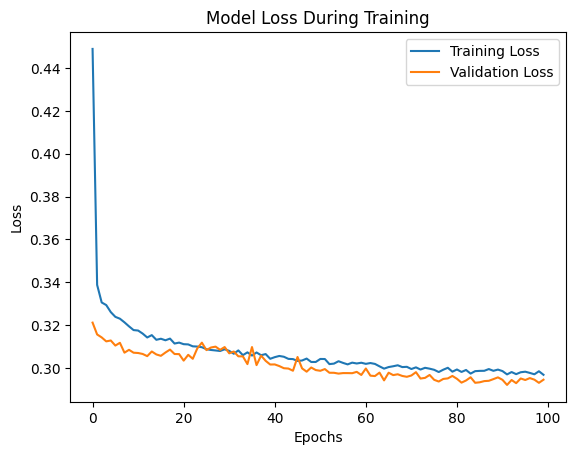

In [30]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


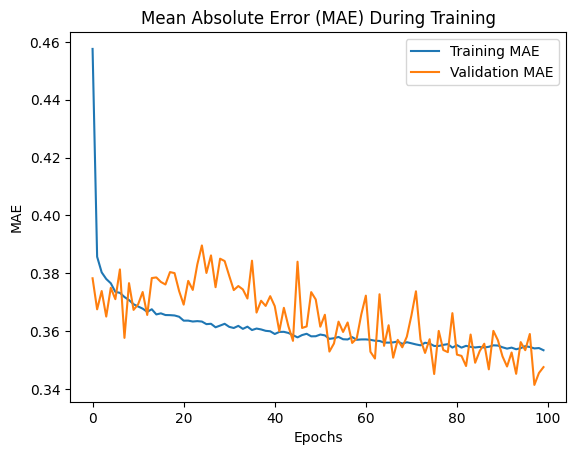

In [31]:
# Plot training & validation MAE values

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error (MAE) During Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['Training MAE', 'Validation MAE'])
plt.show()


**Observations:**

Look at both the plots, we can say

1. **Model Performance:** 
The steady decline in both MAE and loss, along with the small gap between training and validation metrics, indicates that the model is performing well and generalizing effectively.

2. **No Overfitting:** 
There is no significant divergence between training and validation metrics, suggesting that overfitting is not a concern here.

**Model prediction**

In [32]:
# Let's predict on the test data

y_pred = model.predict(X_test_lstm)
y_pred


433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[1.3471476 ],
       [0.45949215],
       [1.0818843 ],
       ...,
       [0.42367327],
       [0.8396231 ],
       [0.38185847]], dtype=float32)

In [33]:
# Inverse transform the predicted and actual values

y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform for predictions
y_test_rescaled = y_scaler.inverse_transform(y_test.values.reshape(-1, 1))  # Rescale y_test if it was scaled

In [34]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Compute metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
explained_variance = explained_variance_score(y_test_rescaled, y_pred_rescaled)

# Print the results
print("Validation Metrics:\n")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")


Validation Metrics:

Mean Squared Error (MSE): 17.8618
Root Mean Squared Error (RMSE): 4.2263
R² Score: 0.6712
Explained Variance Score: 0.6714


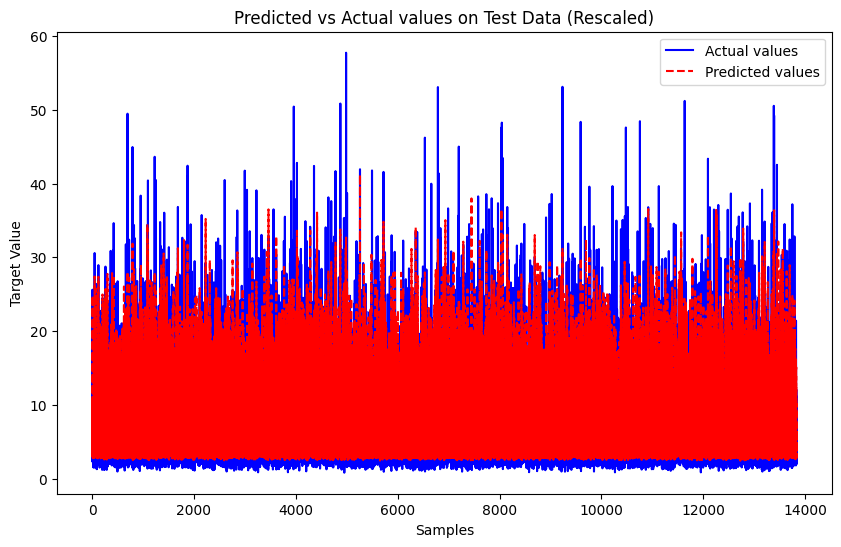

In [35]:
# Let's plot predicted vs actual values

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual values', color='blue')
plt.plot(y_pred_rescaled, label='Predicted values', color='red', linestyle='dashed')
plt.title('Predicted vs Actual values on Test Data (Rescaled)')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.legend()
plt.show()

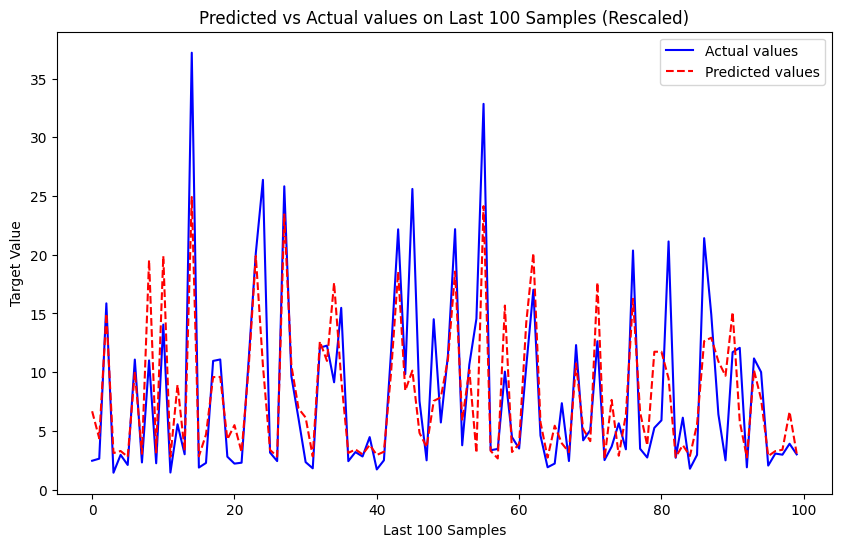

In [36]:
# For better visualization, let's plot predicted vs actual values for last 100 samples

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[-100:], label='Actual values', color='blue')
plt.plot(y_pred_rescaled[-100:], label='Predicted values', color='red', linestyle='dashed')
plt.title('Predicted vs Actual values on Last 100 Samples (Rescaled)')
plt.xlabel('Last 100 Samples')
plt.ylabel('Target Value')
plt.legend()
plt.show()

---

#### **Conclusion**

---

The LSTM model demonstrates strong potential, delivering impressive results. Further fine-tuning of its parameters and experimenting with resampled data at 15-minute and 60-minute intervals could enhance its performance even further.

Additionally, exploring alternative time series models such as Informer, LSTM with Attention, SARIMAX, or Prophet is a worthwhile consideration, as these models may offer even better outcomes depending on the specific characteristics of the dataset and the forecasting objectives.

---